# Natural Language Processing 
# Movie Review Classifier

## Importing the Libraries

In [90]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras as layers
import keras as losses

## Importing the dataset

### Here it is the movie dataset from Stanford University

In [91]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

os.listdir(dataset_dir)

train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())



Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Preprocessing the Data

### Training, Testing and defining the label for classification

In [92]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of

### Create validation and test datasets and defines a custom text standardization function

In [93]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### Vectorizing the text data

In [94]:
tf.keras.layers.TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    
    
)

### Create test Dataset without labels

In [95]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

### Printing the batches

In [96]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))


Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  85,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2421,
           1,   51,   22,   25,  404,  251,   12,  308,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

### Analysing the vocabulary created by the vectorize_layer and the total vocabulary size

In [97]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  lovely
 313 --->  american
Vocabulary size: 10000


### Training and Testing the Data

In [98]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Optimizing the performance of your TensorFlow data input pipelines using caching and prefetching

In [99]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Defining the body of the NLP

In [100]:
embedding_dim=16

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features + 1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])



model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_10 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_5   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 


 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### Optimising 

In [101]:
model.compile(optimizer='adam',loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])


### Running Epochs

In [102]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 16s 25ms/step - loss: 0.6628 - accuracy: 0.5073 - val_loss: 0.6126 - val_accuracy: 0.5374
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5463 - accuracy: 0.6668 - val_loss: 0.4962 - val_accuracy: 0.7308
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4424 - accuracy: 0.7935 - val_loss: 0.4188 - val_accuracy: 0.8090
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3767 - accuracy: 0.8380 - val_loss: 0.3731 - val_accuracy: 0.8330
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3345 - accuracy: 0.8625 - val_loss: 0.3448 - val_accuracy: 0.8442
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3043 - accuracy: 0.8765 - val_loss: 0.3260 - val_accuracy: 0.8548
Epoch 7/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2812 - accuracy: 0.8882 - val_loss: 0.3127 - val_accuracy: 0.8600
Epoc

### Calculating the Accuracy

In [103]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 43s 55ms/step - loss: 0.3106 - accuracy: 0.8610
Loss:  0.3105659484863281
Accuracy:  0.8610000014305115


In [104]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Checking the statistics

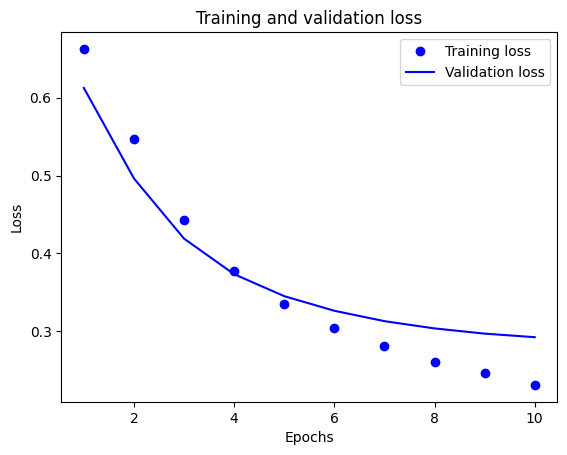

In [105]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Running Final accuracy

In [106]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model
])

export_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 7s 9ms/step - loss: 0.3106 - accuracy: 0.8610
0.8610000014305115


## Testing the NLP with example

In [107]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]


numerical_predictions = export_model.predict(examples)

def get_string_label(prediction):
    if prediction >= 0:
        return "Positive"
    else:
        return "Negative"


string_predictions = [get_string_label(pred) for pred in numerical_predictions]


for example, prediction in zip(examples, string_predictions):
    print(f"Review: {example}")
    print(f"Sentiment: {prediction}\n")



1/1 [==============================] - 0s 82ms/step
Review: The movie was great!
Sentiment: Positive

Review: The movie was okay.
Sentiment: Negative

Review: The movie was terrible...
Sentiment: Negative

